In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_ALL, '' )
%matplotlib inline

from ingestion import read_asec_data, read_asec_dictionary
from analysis import add_quantiles

Number of records:
* Household: 94,097
* Family: 80,610
* Person: 185,487

In [2]:
# I am not at all sure if it's more appropriate to do this at a personal level or household level;
# I am guessing personal, since that is how federal income tax is administered, so we're going with
# that for now.

# We are also using the taxable income amount for the time being, again I don't know if this is necessarily
# the right approach, but it seems plausible as a first pass.

# TODO: Read up more on the various income metrics

person_df = read_asec_data('data/asec2016_pubuse_v3.dat', 'data/asec2016_dd.txt', 'person',
                         ['MARSUPWT', 'TAX_INC', 'WSAL_VAL', 'FEDTAX_BC', 'FEDTAX_AC'], as_df=True)

In [3]:
person_df.head()

,fedtax_ac,fedtax_bc,marsupwt,tax_inc,wsal_val
0,0,0,1132.05,0,0
1,0,0,1077.54,0,0
2,0,0,1077.54,0,0
3,10,10,1151.49,101,0
4,-2490,0,705.00,0,6000


In [4]:
print('No income: {}'.format(len(person_df[person_df['tax_inc'] > 0])))
print('Total: {}'.format(len(person_df)))
print('Fraction: {}'.format(float(len(person_df[person_df['tax_inc'] > 0])) / len(person_df)))

No income: 63058
Total: 185487
Fraction: 0.339959134602


In [5]:
person_df.loc[person_df['wsal_val'] == 0, 'marsupwt'].sum()/person_df['marsupwt'].sum()

0.5166817057846115

In [6]:
person_df = add_quantiles(person_df, 'wsal_val')
# quantiled['samp_prob'] = quantiled['marsupwt'] / quantiled['marsupwt'].sum()
# quantiled = quantiled.sort_values('wsal_val')
# quantiled['wsal_quantile'] = np.cumsum(quantiled['samp_prob'])
person_df[person_df['wsal_val_quantile'] >= .99].head()

,fedtax_ac,fedtax_bc,marsupwt,tax_inc,wsal_val,wsal_val_quantile
18571,102117,102117,3574.08,430831,190000,0.990011
38355,64462,64462,3267.85,283131,190000,0.990021
152268,55314,55314,1567.19,244501,190000,0.990026
19910,34492,34492,1457.42,169431,190000,0.990030
39017,41704,41704,4573.23,173690,190000,0.990045


So if you earn more than \$190k, you're in the top 1%, according to this. Let's try this with the population of people who had wages more than $0:

In [7]:
earners = person_df[person_df['wsal_val'] > 0]
earners = add_quantiles(earners, 'wsal_val')
earners[earners['wsal_val_quantile'] >= .99].head()

,fedtax_ac,fedtax_bc,marsupwt,tax_inc,wsal_val,wsal_val_quantile
158002,0,0,2206.06,0,250000,0.990004
39914,41244,41244,1935.37,185494,250000,0.990016
159107,80456,80456,1890.08,317960,250000,0.990028
72734,0,0,2469.20,0,250000,0.990045
23042,0,0,1649.35,0,250000,0.990055


So earning \$250k puts you in the top 1% of people who earned wages last year.

Let's try this with households, to see if we can match that Excel worksheet from the census website:

In [8]:
hh_df = read_asec_data('data/asec2016_pubuse_v3.dat', 'data/asec2016_dd.txt', 'household',
                         ['HSUP_WGT', 'HTOTVAL'], as_df=True)
hh_df = add_quantiles(hh_df, 'htotval', weight='hsup_wgt')
hh_df[abs(hh_df['htotval'] - 250000) == min(abs(hh_df['htotval']-250000))]

,hsup_wgt,htotval,htotval_quantile
5733,943.88,250000,0.966734
46214,1915.13,250000,0.966749
59628,1271.44,250000,0.966759
74091,171.53,250000,0.966760
86342,1497.28,250000,0.966772
68576,1536.90,250000,0.966784
8494,3274.97,250000,0.966810
61090,895.70,250000,0.966817
65472,4077.60,250000,0.966850


This is exactly what the Excel spreadsheet gives, to within .0005%.

So now let's plot the distribution of personal income in the US, both for people who earned wages and people who did not. We'll just start from scratch:

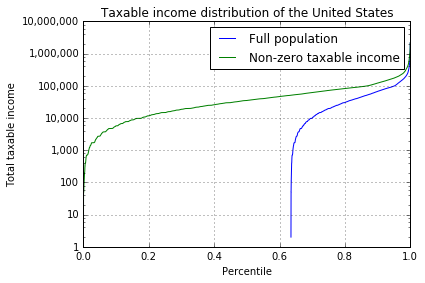

In [9]:
metric = 'tax_inc'
full_population = add_quantiles(person_df, metric)
person_df = add_quantiles(person_df, metric)
earners_only = add_quantiles(person_df[person_df[metric] > 0], metric)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(full_population['{}_quantile'.format(metric)], full_population[metric], label='Full population')
ax.semilogy(earners_only['{}_quantile'.format(metric)], earners_only[metric], label='Non-zero taxable income')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(True)
ax.set_ylabel('Total taxable income')
ax.set_xlabel('Percentile')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

Let's try the PDF of these:

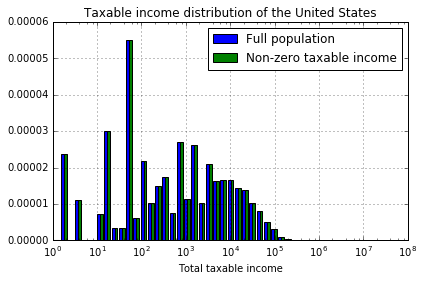

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([full_population[metric], earners_only[metric]], np.logspace(0, 8, num=50), normed=1,
        histtype='bar', label=['Full population', 'Non-zero taxable income'])
ax.grid(True)
ax.set_xscale('log')
ax.set_xlabel('Total taxable income')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

The logspace makes the distributions the same, since you can't show zero, so let's just try a linear scale:

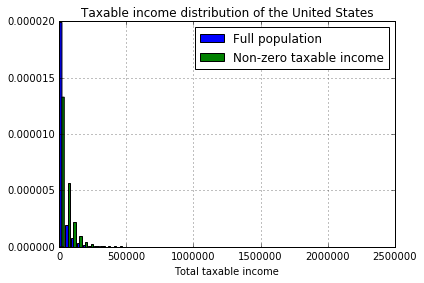

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([full_population[metric], earners_only[metric]], bins=50, normed=1,
        histtype='bar', label=['Full population', 'Non-zero taxable income'])
ax.grid(True)
ax.set_xlabel('Total taxable income')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

Let's try looking at tax liability, since that's ultimately what we care about:

In [12]:
metrics = ['fedtax_bc', 'fedtax_ac']
person_df = add_quantiles(person_df, metrics)
earners_only = add_quantiles(earners_only, metrics)

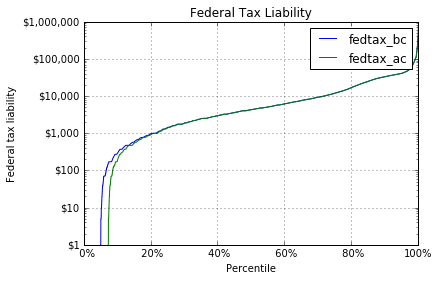

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
for metric in metrics:
    earners_only = earners_only.sort_values('{}_quantile'.format(metric))
    ax.semilogy(earners_only['{}_quantile'.format(metric)], earners_only[metric], label=metric)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '${:,.0f}'.format(x)))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x*100)))
ax.grid(True)
ax.legend()
ax.set_title('Federal Tax Liability')
ax.set_xlabel('Percentile')
ax.set_ylabel('Federal tax liability')

In [14]:
min(earners_only.loc[earners_only[metric]>0, '{}_quantile'.format(metric)])

0.073911713763230719

In [15]:
earners_only.loc[earners_only[metric]>0].sort_values(metric).head()

,fedtax_ac,fedtax_bc,marsupwt,tax_inc,wsal_val,wsal_val_quantile,tax_inc_quantile,fedtax_bc_quantile,fedtax_ac_quantile
105909,1,1,863.41,14,0,0.003306,0.000067,0.051295,0.073912
95864,1,1,3474.86,10,10300,0.588415,0.000047,0.051287,0.073942
174222,1,1,1424.41,11,0,0.255630,0.000059,0.051258,0.073954
10875,1,1,1830.33,14,4000,0.546955,0.000082,0.051311,0.073970
77232,2,2,555.24,518,20000,0.646304,0.007515,0.051376,0.074124
